In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"
pd.set_option("display.max_columns", 200)

In [ ]:
CSV_PATH = "Housing.csv"

df = pd.read_csv(CSV_PATH)

print("Перші рядки сирих даних:")
display(df.head())
print("Форма:", df.shape)

Перші рядки сирих даних:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Форма: (545, 13)


In [ ]:
target_col = "price"

# Визначимо числові та категоріальні колонки (у датасеті є і yes/no, і 'furnished' тощо)
num_cols = ["area", "bedrooms", "bathrooms", "stories", "parking"]
cat_cols_binary = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
cat_cols_multi = ["furnishingstatus"]

In [ ]:
for c in num_cols + cat_cols_binary + cat_cols_multi + [target_col]:
    if c not in df.columns:
        raise ValueError(f"У файлі не знайдено колонку: {c}")

# Заповнимо можливі пропуски (у простий спосіб)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
for c in cat_cols_binary + cat_cols_multi:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

# Перетворення yes/no -> 1/0
for c in cat_cols_binary:
    df[c] = df[c].map({"yes": 1, "no": 0}).astype(int)

# One-hot для furnishingstatus
df = pd.get_dummies(df, columns=cat_cols_multi, drop_first=True)

In [ ]:
y = df[target_col].values.reshape(-1, 1)

feature_cols = num_cols + cat_cols_binary + [c for c in df.columns if c.startswith("furnishingstatus_")]
X = df[feature_cols].astype(float).values

# Масштабування (Z-score) ТІЛЬКИ для ознак (не для y)
X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True) + 1e-12
Xz = (X - X_mean) / X_std

In [ ]:
ones = np.ones((Xz.shape[0], 1))
Xb = np.hstack([ones, Xz])    # форма: (n_samples, n_features+1)

n_samples, n_features_plus_bias = Xb.shape
print("Розмір матриці X з bias:", Xb.shape, "| y:", y.shape)

Розмір матриці X з bias: (545, 14) | y: (545, 1)


In [ ]:
rng = np.random.default_rng(42)
idx = np.arange(n_samples)
rng.shuffle(idx)
split = int(0.8 * n_samples)
train_idx, test_idx = idx[:split], idx[split:]

Xtr, ytr = Xb[train_idx], y[train_idx]
Xte, yte = Xb[test_idx], y[test_idx]

In [ ]:
def hypothesis(X, w):
    """h_w(X) = X @ w   (X: [n,m], w: [m,1])"""
    return X @ w

def mse_loss(X, y, w):
    """J(w) = (1/(2n)) * ||Xw - y||^2"""
    n = X.shape[0]
    r = X @ w - y
    return (r.T @ r) / (2*n)

def mse_grad(X, y, w):
    """∇J(w) = (1/n) * X^T (Xw - y)"""
    n = X.shape[0]
    return (X.T @ (X @ w - y)) / n

# ========= 3) Один крок GD + цикл навчання =========
def gd_step(X, y, w, lr=1e-2):
    return w - lr * mse_grad(X, y, w)

def train_gd(X, y, lr=1e-2, iters=2000, w0=None, verbose_every=200):
    m = X.shape[1]
    w = np.zeros((m,1)) if w0 is None else w0.copy()
    hist = []
    for t in range(1, iters+1):
        w = gd_step(X, y, w, lr=lr)
        if t % 10 == 0 or t == 1:
            loss = float(mse_loss(X, y, w))
            hist.append(loss)
        if verbose_every and t % verbose_every == 0:
            print(f"iter={t:4d} | train MSE={float(mse_loss(X,y,w)):.4e}")
    return w, hist

# Підбір lr: кілька варіантів і візьмемо кращий по кінцевому MSE
lrs = [1e-3, 3e-3, 1e-2, 3e-2]
best = (None, np.inf, None)  # (w, loss, hist)
for lr in lrs:
    w_try, hist = train_gd(Xtr, ytr, lr=lr, iters=3000, verbose_every=0)
    loss = float(mse_loss(Xtr, ytr, w_try))
    if loss < best[1]:
        best = (w_try, loss, hist)
        best_lr = lr

w_gd, train_loss, loss_hist = best[0], best[1], best[2]
print(f"\n[GD] Найкращий lr={best_lr} | train MSE={train_loss:.4e}")

# ========= 4) Аналітичне рішення =========
# w* = (X^T X)^{-1} X^T y   використаємо псевдообернену, щоб уникати виродження
w_ne = np.linalg.pinv(Xtr) @ ytr

/tmp/ipython-input-217467283.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss = float(mse_loss(X, y, w))
/tmp/ipython-input-217467283.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss = float(mse_loss(Xtr, ytr, w_try))



[GD] Найкращий lr=0.03 | train MSE=5.6742e+11


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def rmse_compat(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_model(Xtr, ytr, Xte, yte, w, name="model"):
    ytr_pred = Xtr @ w
    yte_pred = Xte @ w
    rmse_tr = rmse_compat(ytr, ytr_pred)
    rmse_te = rmse_compat(yte, yte_pred)
    r2_tr = r2_score(ytr, ytr_pred)
    r2_te = r2_score(yte, yte_pred)
    print(f"{name:12s} | RMSE tr={rmse_tr:,.1f}  te={rmse_te:,.1f} | R2 tr={r2_tr:.4f}  te={r2_te:.4f}")
    return ytr_pred, yte_pred

In [ ]:
print("\nПорівняння моделей:")
_ = eval_model(Xtr,ytr,Xte,yte,w_gd, name="GD")
_ = eval_model(Xtr,ytr,Xte,yte,w_ne, name="NormalEq")
_ = eval_model(Xtr,ytr,Xte,yte,w_sk, name="sklearn")



Порівняння моделей:
GD           | RMSE tr=1,065,291.5  te=1,043,444.2 | R2 tr=0.6741  te=0.6914
NormalEq     | RMSE tr=1,065,291.5  te=1,043,444.2 | R2 tr=0.6741  te=0.6914
sklearn      | RMSE tr=1,065,291.5  te=1,043,444.2 | R2 tr=0.6741  te=0.6914


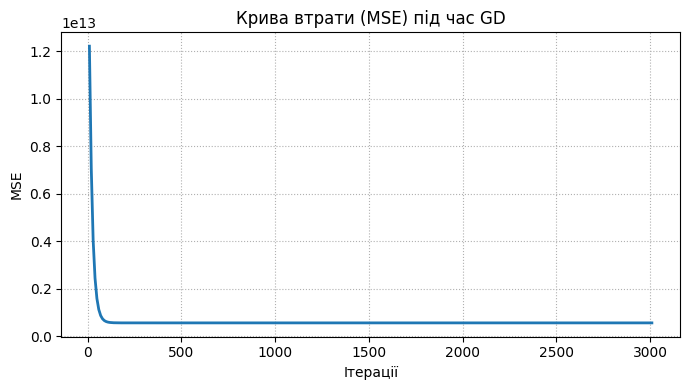

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(loss_hist)+1)*10, loss_hist, lw=2)
plt.title("Крива втрати (MSE) під час GD")
plt.xlabel("Ітерації")
plt.ylabel("MSE")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

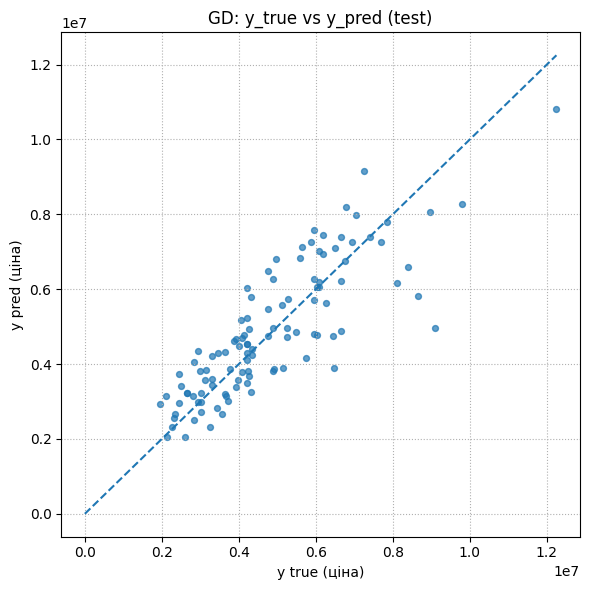

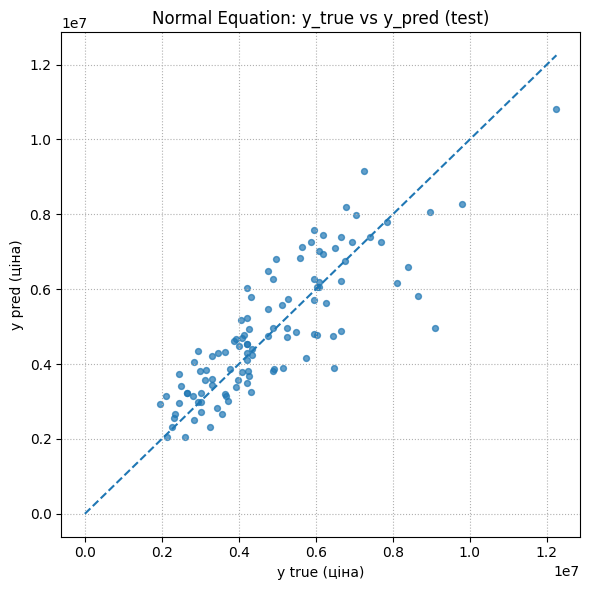

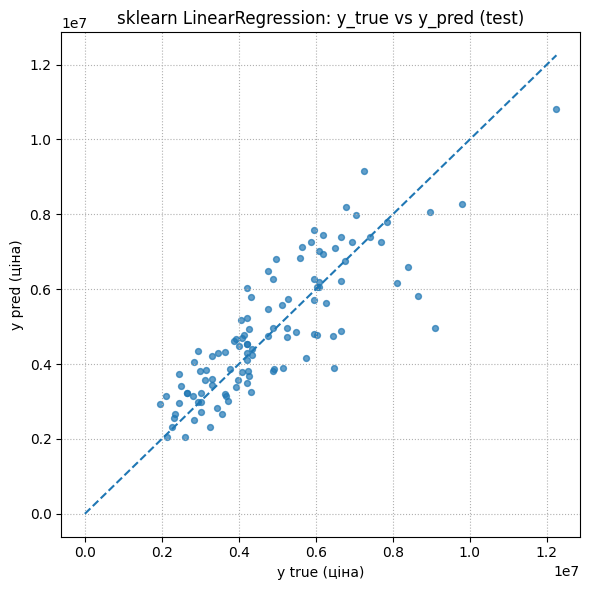

In [ ]:
def scatter_true_pred(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=18, alpha=0.7)
    m = max(y_true.max(), y_pred.max())
    plt.plot([0,m],[0,m],"--", lw=1.5)
    plt.xlabel("y true (ціна)")
    plt.ylabel("y pred (ціна)")
    plt.title(title)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

yte_pred_gd = Xte @ w_gd
yte_pred_ne = Xte @ w_ne
yte_pred_sk = Xte @ w_sk

scatter_true_pred(yte, yte_pred_gd, "GD: y_true vs y_pred (test)")
scatter_true_pred(yte, yte_pred_ne, "Normal Equation: y_true vs y_pred (test)")
scatter_true_pred(yte, yte_pred_sk, "sklearn LinearRegression: y_true vs y_pred (test)")

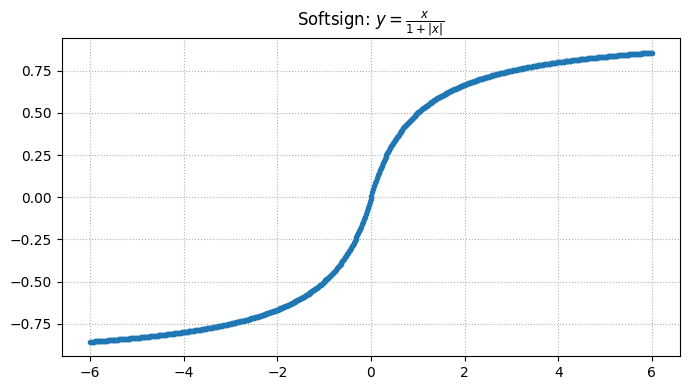

In [ ]:
x = np.linspace(-6,6,600); y = x/(1+np.abs(x))
plt.figure(figsize=(7,4)); plt.plot(x,y,lw=2, linestyle="--", marker=".")
plt.title("Softsign: $y=\\frac{x}{1+|x|}$"); plt.grid(True, ls=":"); plt.tight_layout(); plt.show()

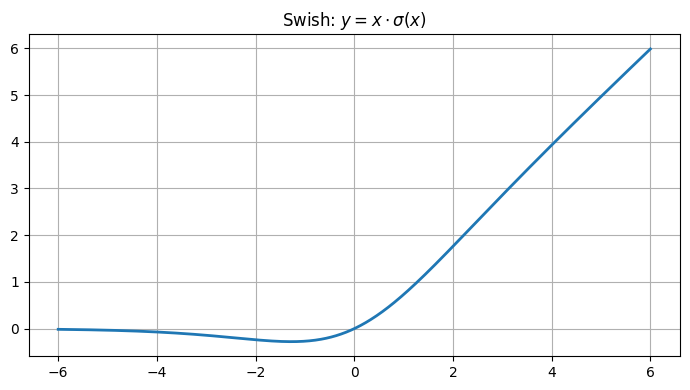

In [ ]:
sigmoid = lambda t: 1/(1+np.exp(-t))
x = np.linspace(-6,6,600); y = x*sigmoid(x)
plt.figure(figsize=(7,4)); plt.plot(x,y,lw=2)
plt.title("Swish: $y=x\\cdot\\sigma(x)$"); plt.grid(True); plt.tight_layout(); plt.show()

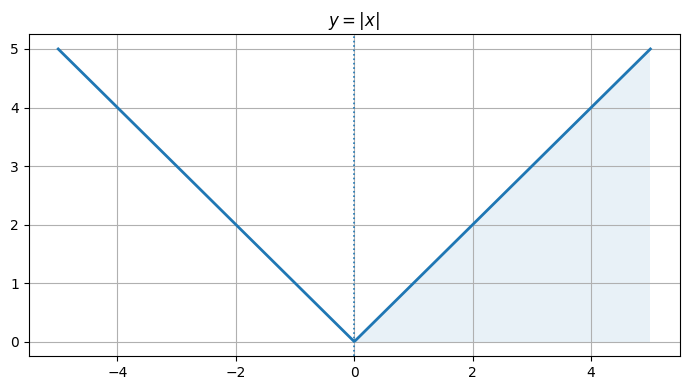

In [ ]:
x = np.linspace(-5,5,400); y = np.abs(x)
plt.figure(figsize=(7,4)); plt.plot(x,y,lw=2); plt.axvline(0, ls=":", lw=1.2)
plt.fill_between(x,y,where=(x>=0),alpha=.1,step="mid")
plt.title("$y=|x|$"); plt.grid(True); plt.tight_layout(); plt.show()

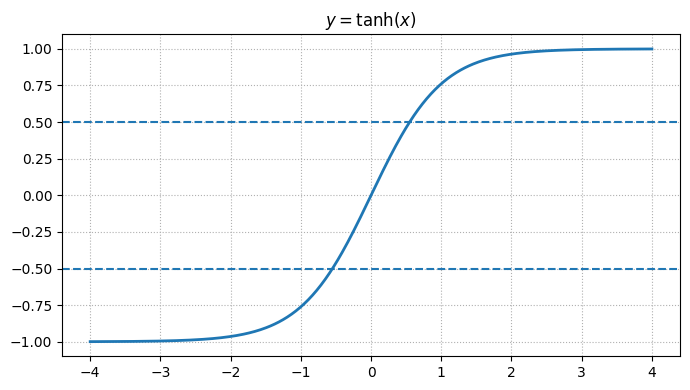

In [ ]:
x = np.linspace(-4,4,400); y = np.tanh(x)
plt.figure(figsize=(7,4)); plt.plot(x,y,lw=2); plt.axhline(.5, ls="--"); plt.axhline(-.5, ls="--")
plt.title("$y=\\tanh(x)$"); plt.grid(True, ls=":"); plt.tight_layout(); plt.show()

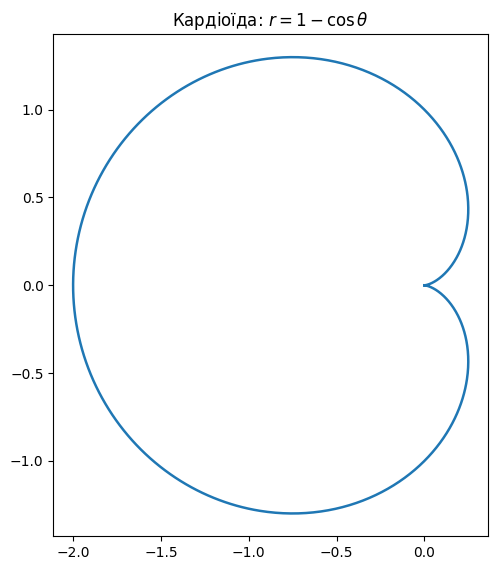

In [ ]:
theta = np.linspace(0,2*np.pi,1000); r = 1 - np.cos(theta)
Xc, Yc = r*np.cos(theta), r*np.sin(theta)
plt.figure(figsize=(5.8,5.8)); plt.plot(Xc,Yc,lw=1.8); plt.gca().set_aspect("equal","box")
plt.title("Кардіоїда: $r=1-\\cos\\theta$"); plt.tight_layout(); plt.show()